# Building ML Models for SRF Fault Classification
Chris Tennant <br>
_December 17, 2019_
***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from pathlib import Path

In [2]:
dir = Path('C:/Users/tennant/Desktop/rfw_tsf_extractor-Spring-2018/extracted')

In [3]:
X_train_scaled_top50 = pd.read_csv(dir/'X_fault_train_scaled_top50.csv')
X_test_scaled_top50 = pd.read_csv(dir/'X_fault_test_scaled_top50.csv')
y_train = pd.read_csv(dir/'y_fault_train.csv', header=None)
y_test = pd.read_csv(dir/'y_fault_test.csv', header=None)

In [4]:
X_train_scaled_top50 = X_train_scaled_top50.drop(columns='Unnamed: 0')
X_test_scaled_top50 = X_test_scaled_top50.drop(columns='Unnamed: 0')
y_train.columns = ['index', 'label']
y_test.columns = ['index', 'label']
y_train = y_train.drop(columns='index')
y_test = y_test.drop(columns='index')

In [5]:
print("Number of training examples: {}".format(X_train_scaled_top50.shape[0]))
print("Number of testing examples: {}".format(X_test_scaled_top50.shape[0]))
print("Number of features: {}".format(X_train_scaled_top50.shape[1]))
print("Number of categories: {}".format(y_test['label'].nunique()))

Number of training examples: 231
Number of testing examples: 99
Number of features: 50
Number of categories: 4


In [70]:
RF_top50 = ['GMES__fft_coefficient__coeff_16__attr_"real"',
 'PLDE__fft_coefficient__coeff_16__attr_"real"',
 'GMES__fft_coefficient__coeff_11__attr_"angle"',
 'PMES__index_mass_quantile__q_0.9',
 'CRRP__fft_coefficient__coeff_64__attr_"imag"',
 'CRRP__fft_coefficient__coeff_79__attr_"abs"',
 'CRFP__ar_coefficient__k_10__coeff_1',
 'GMES__fft_coefficient__coeff_63__attr_"imag"',
 'PMES__fft_coefficient__coeff_0__attr_"abs"',
 'CRRP__maximum',
 'PMES__index_mass_quantile__q_0.8',
 'GMES__fft_coefficient__coeff_30__attr_"imag"',
 'GMES__fft_coefficient__coeff_79__attr_"angle"',
 'IMES__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.8',
 'IMES__fft_coefficient__coeff_2__attr_"abs"',
 'PLDE__minimum',
 'PLDE__fft_coefficient__coeff_28__attr_"real"',
 'IMES__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.8',
 'CRRP__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"stderr"',
 'DFQES__fft_coefficient__coeff_52__attr_"abs"',
 'CRRP__approximate_entropy__m_2__r_0.5',
 'CRRP__fft_coefficient__coeff_29__attr_"abs"',
 'CRRP__fft_coefficient__coeff_48__attr_"imag"',
 'DFQES__ratio_value_number_to_time_series_length',
 'PMES__number_peaks__n_5',
 'PMES__energy_ratio_by_chunks__num_segments_10__segment_focus_5',
 'PLDE__fft_coefficient__coeff_49__attr_"angle"',
 'IMES__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"',
 'CRRP__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"intercept"',
 'GASK__ar_coefficient__k_10__coeff_1',
 'CRRP__fft_coefficient__coeff_75__attr_"angle"',
 'IASK__fft_coefficient__coeff_45__attr_"abs"',
 'DETA2__number_peaks__n_3',
 'CRFPP__percentage_of_reoccurring_values_to_all_values',
 'CRRP__fft_coefficient__coeff_64__attr_"angle"',
 'GMES__fft_coefficient__coeff_28__attr_"real"',
 'CRRP__fft_coefficient__coeff_31__attr_"abs"',
 'CRRP__fft_coefficient__coeff_96__attr_"imag"',
 'GASK__ratio_beyond_r_sigma__r_10',
 'PLDE__fft_coefficient__coeff_33__attr_"real"',
 'CRRP__fft_coefficient__coeff_33__attr_"abs"',
 'CRRP__standard_deviation',
 'GMES__spkt_welch_density__coeff_5',
 'CRRP__fft_coefficient__coeff_76__attr_"abs"',
 'PLDE__fft_coefficient__coeff_17__attr_"abs"',
 'DFQES__fft_coefficient__coeff_51__attr_"abs"',
 'CRFP__time_reversal_asymmetry_statistic__lag_1',
 'DFQES__fft_coefficient__coeff_50__attr_"real"',
 'IMES__linear_trend__attr_"rvalue"',
 'PMES__energy_ratio_by_chunks__num_segments_10__segment_focus_9']

Import libraries containing performance metrics and models.

In [71]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier

from matplotlib import pyplot

Evaluate models using code from *"Machine Learning Mastery with Python"*.<br>
Model performance is evaluated using _k_-folds cross-validation, so the test set remains untouched.

In [72]:
# prepare models
models = []
#non-linear models
models.append(('KNN', KNeighborsClassifier(n_neighbors=4)))
models.append(('DT', DecisionTreeClassifier()))
models.append(('SVC', SVC(gamma='auto')))
models.append(('BAYES', GaussianNB()))
# ensemble models
models.append(('BAG', BaggingClassifier(n_estimators=100)))
models.append(('RF', RandomForestClassifier(n_estimators=100)))
models.append(('XT', ExtraTreesClassifier(n_estimators=100)))
models.append(('GBM', GradientBoostingClassifier(n_estimators=100)))
#models.append(('AB', AdaBoostClassifier(n_estimators=100)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, random_state=7)
    cv_results = cross_val_score(model, X_train_scaled_top50, np.ravel(y_train), cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

KNN: 0.926364 (0.042660)
DT: 0.904718 (0.032643)
SVC: 0.939408 (0.037373)
BAYES: 0.865772 (0.057405)
BAG: 0.948011 (0.044801)
RF: 0.956707 (0.033680)
XT: 0.961055 (0.037382)
GBM: 0.939685 (0.049569)


In [73]:
np.save('FAULT_CV_results', results, allow_pickle=False)
names #need to copy and paste or find another way to write list to file

['KNN', 'DT', 'SVC', 'BAYES', 'BAG', 'RF', 'XT', 'GBM']

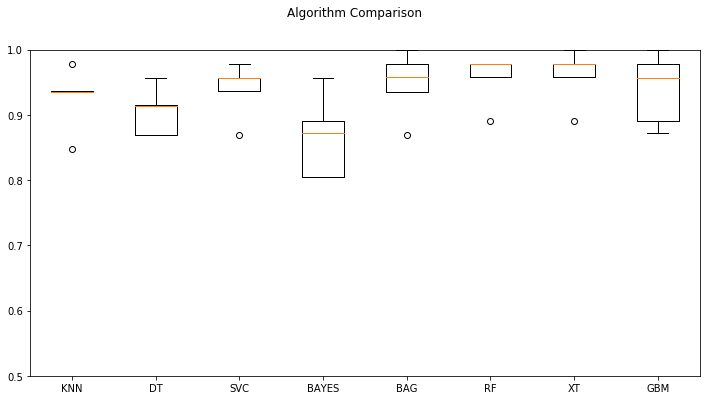

In [74]:
# boxplot algorithm comparison
fig = pyplot.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.ylim((0.5,1))
pyplot.show()

Choose the `RandomForest` for its performance and also robustness against overfitting. Use `GridSearch` to perform hyperparameter tuning.

In [76]:
from sklearn.model_selection import GridSearchCV
parameter_candidates = {'n_estimators': np.arange(25,250,25), 'min_samples_split': np.arange(2,18,1), 'max_depth': np.arange(2,18,1)}

In [77]:
# create a classifier object with the classifier and parameter candidates
clf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=parameter_candidates, verbose=1, cv=5)

# train the classifier 
%time clf.fit(X_train_scaled_top50, np.ravel(y_train)) 

Fitting 5 folds for each of 2304 candidates, totalling 11520 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Wall time: 20min 18s


[Parallel(n_jobs=1)]: Done 11520 out of 11520 | elapsed: 20.3min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': array([ 25,  50,  75, 100, 125, 150, 175, 200, 225]), 'min_samples_split': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]), 'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [78]:
# view the accuracy score
print('Best accuracy score for training data:', clf.best_score_) 

# view the best parameters for the model found using grid search
print('Best min_samples_split:', clf.best_estimator_.min_samples_split)
print('Best max_depth:', clf.best_estimator_.max_depth)
print('Best n_estimators:', clf.best_estimator_.n_estimators)

Best accuracy score for training data: 0.9783549783549783
Best min_samples_split: 6
Best max_depth: 6
Best n_estimators: 125


Use the best parameters to define the model.

In [79]:
RF_model_top = RandomForestClassifier(n_estimators=125, max_depth=6, min_samples_split=6, max_features=None, random_state=11)
RF_model_top.fit(X_train_scaled_top50, np.ravel(y_train))
print(RF_model_top.score(X_test_scaled_top50, np.ravel(y_test)))

0.8888888888888888


Save final `RandomForestClassifier` model using `joblib` (more [here](https://chrisalbon.com/machine_learning/basics/saving_machine_learning_models/)). Note, this model has been trained on the *top 50* the features.

In [6]:
# save model using joblib
from sklearn.externals import joblib

filename_joblib = 'RF_FAULT_top50_12172019_TMP.sav'
#joblib.dump(RF_model_top, filename_joblib)

# save model using pickle
from pickle import dump
from pickle import load

filename_pickle = 'RF_FAULT_top50.pkl'
#dump(RF_model_top, open(filename_pickle, 'wb'))

In [81]:
scores = cross_val_score(RF_model_top, X_train_scaled_top50, np.ravel(y_train), cv=5)
print("The mean accuracy score is: ({:.2f} +/- {:.2f})%".format(100*scores.mean(), 100*scores.std()))

The mean accuracy score is: (94.84 +/- 2.91)%


Generate a `classification_report` using the `RandomForestClassifier`.

In [82]:
y_pred = RF_model_top.fit(X_train_scaled_top50, np.ravel(y_train)).predict(X_test_scaled_top50)
print(classification_report(np.ravel(y_test), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.89      0.53      0.67        15
           2       0.86      0.94      0.90        34
           3       0.89      0.95      0.92        42

   micro avg       0.89      0.89      0.89        99
   macro avg       0.91      0.86      0.87        99
weighted avg       0.89      0.89      0.88        99



In [83]:
conf_mx = confusion_matrix(np.ravel(y_test), y_pred)

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

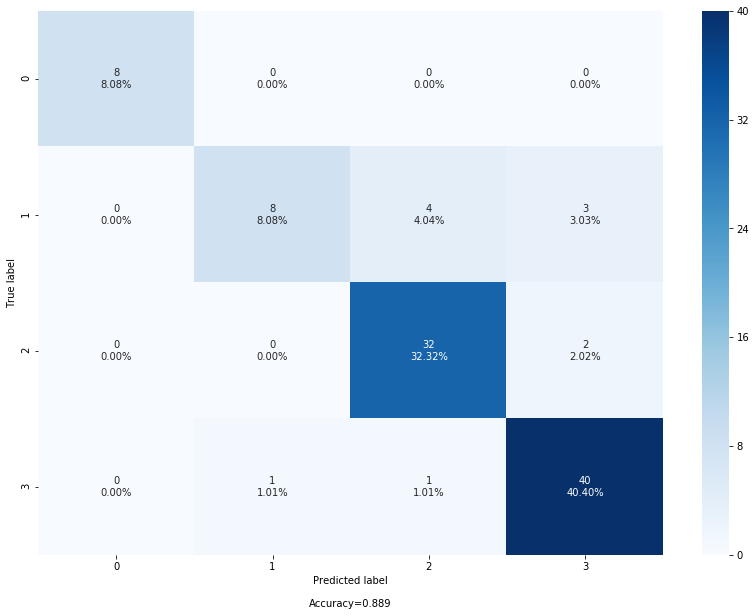

In [85]:
make_confusion_matrix(conf_mx, figsize=(14,10), cbar=True)

Check that the model can be loaded.

In [7]:
#RF_from_pickle = load(open('./models/RF_FAULT_top50.pkl', 'rb'))
RF_from_joblib = joblib.load('RF_FAULT_top50_12172019.sav')

Use the loaded model to make predictions.

In [8]:
print(RF_from_joblib.score(X_test_scaled_top50, np.ravel(y_test)))

0.8888888888888888
